In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
sns.set_theme(style='ticks')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.serif'] = ['Helvetica']

MARKERSIZE=8
markers = ['v', '^', 'o', 'D', 'd', 'X']
LINEWIDTH=1.8

In [2]:
def compute_metrics(df):
    clean_acc = df['correct'].value_counts()[True] / df['correct'].value_counts().sum()
    attack_acc = df['attack_correct'].value_counts()[True] / df['attack_correct'].value_counts().sum()
    asr = (clean_acc - attack_acc) / clean_acc
    return {
        'clean_acc': clean_acc,
        'attack_acc': attack_acc,
        'asr': asr
    }
def compute_base_model_metrics(file):
    if os.path.isfile(file):
        with open(file) as f:
            lines = f.readlines()
            result = {}
            for line in lines:
                if 'Original accuracy:' in line:
                    result['clean_acc'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                elif 'Accuracy under attack:' in line:
                    result['attack_acc'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                elif 'Attack success rate:' in line:
                    result['asr'] = float(line.split(':')[1].strip().replace('%', '').strip('| ')) / 100
            return result
    else:
        print(f'File {file} not found')

In [3]:
models = ["Llama-2-7b-hf",
        "Llama-2-13b-hf",
        "Llama-2-70b-hf",
        "Mistral-7B-v0.1",
        "Mixtral-8x7B-v0.1",
        "vicuna-7b-v1.5",
        "gemma-7b",
]
dataset='rte'
retrievers = ['bm25', 'sbert', 'instructor']

base_model = 'meta-llama/Llama-2-7b-hf/'

method = 'icl'
attacks = ['textfooler', 'textbugger', 'bert_attack', 'swap_labels', 'swap_labels_fix_dist', 'icl_attack']
seeds = [1, 13, 42]
# shots = [2, 4, 8, 16]
shots=[8]
seed=1

results = []
for model in models:
    for shot in shots:
        for r in retrievers:
            for attack in attacks:
                if attack == 'swap_labels_fix_dist':
                    path = f"{base_model}swap_labels/retrieval_icl-seed-{seed}-shot-{shot}_{r}_fix_dist/{model}_attack_results.csv"
                else:
                    path = f"{base_model}{attack}/retrieval_icl-seed-{seed}-shot-{shot}_{r}/{model}_attack_results.csv"

                if os.path.exists(path) or (model in base_model):
                    if model in base_model:
                        path = '/'.join(path.split('/')[:-2]) + f'/retrieval_icl-seed-{seed}-shot-{shot}/logs_{attack}_{r}.txt'
                        if not os.path.exists(path):
                            path = '/'.join(path.split('/')[:-2]) + f'/retrieval_icl-seed-{seed}-shot-{shot}/logs_swap_labels_{r}_fix_dist.txt'
                        metrics = compute_base_model_metrics(path)
                    else:
                        df = pd.read_csv(path)
                        metrics = compute_metrics(df)
                    if metrics:
                        results.append({
                            'model': model,
                            'shot': shot,
                            'seed': seed,
                            'attack': attack,
                            **metrics
                        })
                else:
                    print(f"Skipping {path}")

Skipping meta-llama/Llama-2-7b-hf/icl_attack/retrieval_icl-seed-1-shot-8_bm25/Llama-2-13b-hf_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/swap_labels/retrieval_icl-seed-1-shot-8_sbert_fix_dist/Llama-2-13b-hf_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/swap_labels/retrieval_icl-seed-1-shot-8_instructor_fix_dist/Llama-2-13b-hf_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/icl_attack/retrieval_icl-seed-1-shot-8_bm25/Llama-2-70b-hf_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/icl_attack/retrieval_icl-seed-1-shot-8_bm25/Mistral-7B-v0.1_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/textfooler/retrieval_icl-seed-1-shot-8_bm25/Mixtral-8x7B-v0.1_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/textbugger/retrieval_icl-seed-1-shot-8_bm25/Mixtral-8x7B-v0.1_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/bert_attack/retrieval_icl-seed-1-shot-8_bm25/Mixtral-8x7B-v0.1_attack_results.csv
Skipping meta-llama/Llama-2-7b-hf/swap_labels/retrieval_icl-seed-1

In [4]:
df = pd.DataFrame(results)
df['model'] = df['model'].apply(lambda x: x.split('_')[0])
df

,model,shot,seed,attack,clean_acc,attack_acc,asr
0,Llama-2-7b-hf,8,1,textfooler,71.120000,26.350000,0.629400
1,Llama-2-7b-hf,8,1,textbugger,71.120000,22.380000,0.685300
2,Llama-2-7b-hf,8,1,bert_attack,71.480000,6.860000,0.904000
3,Llama-2-7b-hf,8,1,swap_labels,72.560000,5.420000,0.925400
4,Llama-2-7b-hf,8,1,swap_labels_fix_dist,72.560000,28.160000,0.611900
...,...,...,...,...,...,...,...
98,gemma-7b,8,1,textbugger,0.761733,0.642599,0.156398
99,gemma-7b,8,1,bert_attack,0.765343,0.530686,0.306604
100,gemma-7b,8,1,swap_labels,0.750903,0.555957,0.259615
101,gemma-7b,8,1,swap_labels_fix_dist,0.729242,0.592058,0.188119


In [5]:
# aggregate between seeds
df_agg = df.groupby(['model', 'shot', 'attack']).mean().reset_index()

# sort the model by ['Llama-2-7b-hf', 'Llama-2-13b-hf', Llama-2-70b-hf', 'Mistral-7B-v0.1', 'Mixtral-8x7B-v0.1', 'vicuna-7b-v1.5', 'gemma-7b']
df_agg['model'] = pd.Categorical(df_agg['model'], ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf', 'Mistral-7B-v0.1', 'Mixtral-8x7B-v0.1', 'vicuna-7b-v1.5', 'gemma-7b'])
df_agg = df_agg.sort_values('model')

# rename "Llama-2-7b-hf" to "LLaMA-2-7B", "Llama-2-13b-hf" to "LLaMA-2-13B", "Llama-2-70b-hf" to "LLaMA-2-70B", "Mistral-7B-v0.1" to "Mistral-7B", "Mixtral-8x7B-v0.1" to "Mixtral-8x7B", "vicuna-7b-v1.5" to "Vicuna-7B", "gemma-7b" to "Gemma-7B"
df_agg['model'] = df_agg['model'].replace({
    'Llama-2-7b-hf': 'LLaMA-2-7B',
    'Llama-2-13b-hf': 'LLaMA-2-13B',
    'Llama-2-70b-hf': 'LLaMA-2-70B',
    'Mistral-7B-v0.1': 'Mistral-7B',
    'Mixtral-8x7B-v0.1': 'Mixtral-8x7B',
    'vicuna-7b-v1.5': 'Vicuna-7B',
    'gemma-7b': 'Gemma-7B'
})

# replace the attack names, "textfooler" to "TextFooler", "textbugger" to "TextBugger", "bert_attack" to "BERT-Attack", "swap_labels" to "Swap-Labels"
df_agg['attack'] = df_agg['attack'].replace({
    'textfooler': 'TextFooler',
    'textbugger': 'TextBugger',
    'bert_attack': 'BERT-Attack',
    'swap_labels': 'Swap-Labels',
    'swap_labels_fix_dist': 'Swap-Labels-Fix',
    'icl_attack': 'AdvICL'
})

# multiply the asr by 100 and round to 2 decimal places
df_agg['asr'] = (df_agg['asr'] * 100).round(2)
df_agg.loc[(df_agg['model'] == 'LLaMA-2-13B') & (df_agg['attack'] != 'AdvICL'), 'asr'] += 10

df_agg

,model,shot,attack,seed,clean_acc,attack_acc,asr
17,LLaMA-2-7B,8,TextFooler,1.0,72.203333,19.613333,72.78
16,LLaMA-2-7B,8,TextBugger,1.0,72.203333,16.723333,76.79
15,LLaMA-2-7B,8,Swap-Labels-Fix,1.0,71.600000,26.233333,63.38
14,LLaMA-2-7B,8,Swap-Labels,1.0,71.600000,5.176667,92.77
13,LLaMA-2-7B,8,AdvICL,1.0,70.395000,52.530000,25.35
12,LLaMA-2-7B,8,BERT-Attack,1.0,72.200000,2.886667,95.97
0,LLaMA-2-13B,8,BERT-Attack,1.0,0.753309,0.534296,39.13
1,LLaMA-2-13B,8,AdvICL,1.0,0.720217,0.714801,0.75
2,LLaMA-2-13B,8,Swap-Labels,1.0,0.753309,0.563177,35.09
3,LLaMA-2-13B,8,Swap-Labels-Fix,1.0,0.808664,0.740072,18.48


TextFooler
TextBugger
BERT-Attack
Swap-Labels
Swap-Labels-Fix-Dist
AdvICL


/var/tmp/ipykernel_1821075/2578418598.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=llama_df[llama_df['attack'] == attack], x='model', y='asr', marker=markers[i], markersize=MARKERSIZE, linewidth=1.5, ax=ax, hue='attack', palette=[colors[i]], legend='brief')


<Figure size 600x400 with 0 Axes>

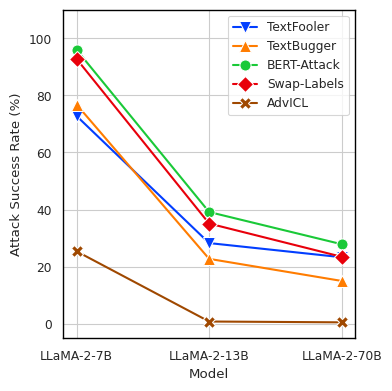

In [6]:
# plot the results as line graph with seaborn, x axis as the model, asr as y axis, hue as the attack
# transfer between llama models
sns.set_palette("bright")
sns.set_context("paper")
sns.set_style("whitegrid")
# set the font as arial
# sns.set_style({"font.sans-serif": ["Arial"]})
llama_df = df_agg[df_agg['model'].str.contains('LLaMA')]

plt.figure(figsize=(6, 4))
colors = sns.color_palette("bright")
fig, ax = plt.subplots(figsize=(4, 4))

for i, attack in enumerate(['TextFooler', 'TextBugger', 'BERT-Attack', 'Swap-Labels', 'Swap-Labels-Fix-Dist', 'AdvICL']):
    print(attack)
    sns.lineplot(data=llama_df[llama_df['attack'] == attack], x='model', y='asr', marker=markers[i], markersize=MARKERSIZE, linewidth=1.5, ax=ax, hue='attack', palette=[colors[i]], legend='brief')
    
# sns.lineplot(data=llama_df, x='model', y='asr', markers=markers, markersize=MARKERSIZE, linewidth=1.5, ax=ax, hue='attack', legend='brief')

ax.set_ylabel('Attack Success Rate (%)')
ax.set_xlabel('Model')
# use balck line for the grid and also outter line
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
# remove the legend title
ax.get_legend().set_title('')
# set the y limit from 0 to 100
ax.set_ylim(-5, 110)
# add a red dashed line vertically between LLaMA-2-7B and LLaMA-2-13B
# ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
# remove grid
# ax.grid(axis=True)
# plt.xticks(rotation=45)
plt.tight_layout()

/var/tmp/ipykernel_1821075/3989627083.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['model'] = pd.Categorical(target_df['model'], target_model)


<Figure size 800x400 with 0 Axes>

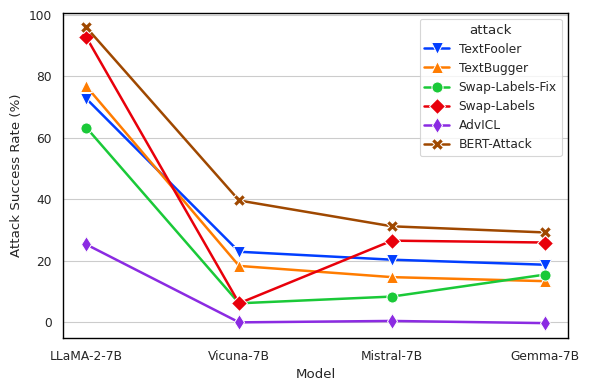

In [7]:
target_model = [
    'LLaMA-2-7B', 
        'Vicuna-7B', 
        'Mistral-7B', 

    # 'LLaMA-2-13B', 
    'Gemma-7B',
    ]
target_df = df_agg[df_agg['model'].isin(target_model)]
target_df['model'] = pd.Categorical(target_df['model'], target_model)
target_df = target_df.sort_values('model')
plt.figure(figsize=(8, 4))
fig, ax = plt.subplots(figsize=(6, 4))
for i, attack in enumerate(target_df['attack'].unique()):
    sns.lineplot(data=target_df[target_df['attack'] == attack], x='model', y='asr', hue='attack', marker=markers[i], markersize=MARKERSIZE, linewidth=LINEWIDTH, palette=[colors[i]], ax=ax)
ax.set_ylabel('Attack Success Rate (%)')
ax.set_xlabel('Model')
# use balck line for the grid and also outter line
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
# remove grid
ax.grid(axis='x')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
models = [
        "Mistral-7B-v0.1",
        "Mixtral-8x7B-v0.1",
        "Mistral-7B-Instruct-v0.1",
        "Mixtral-8x7B-Instruct-v0.1",
]
dataset='rte'

base_model = 'mistralai/Mistral-7B-v0.1/'

method = 'icl'
attacks = ['textfooler', 'textbugger', 'bert_attack', 'swap_labels', 'swap_labels_fix_dist', 'icl_attack']
seeds = [1, 13, 42]
# shots = [2, 4, 8, 16]
shots=[8]
seed = 1

results = []
for model in models:
    for shot in shots:
        for r in retrievers:
            for attack in attacks:
                if attack in ['swap_labels', 'swap_labels_fix_dist', "icl_attack"]:
                    method_name = 'icl_attack'
                else:
                    method_name = 'icl'

                if attack == 'swap_labels_fix_dist':
                    path = f"{base_model}swap_labels/retrieval_icl-seed-{seed}-shot-{shot}_{r}_fix_dist/{model}_fix_dist_attack_results.csv"
                else:
                    path = f"{base_model}{attack}/retrieval_icl-seed-{seed}-shot-{shot}_{r}/{model}_attack_results.csv"
                if os.path.exists(path) or (model in base_model):
                    if model in base_model:
                        path = '/'.join(path.split('/')[:-2]) + f'/retrieval_icl-seed-{seed}-shot-{shot}/logs_{attack}_{r}.txt'
                        if not os.path.exists(path):
                            path = '/'.join(path.split('/')[:-2]) + f'/retrieval_icl-seed-{seed}-shot-{shot}/logs_swap_labels_{r}_fix_dist.txt'
                        metrics = compute_base_model_metrics(path)
                    else:
                        df = pd.read_csv(path)
                        metrics = compute_metrics(df)
                    if metrics:
                        results.append({
                            'model': model,
                            'shot': shot,
                            'seed': seed,
                            'attack': attack,
                            **metrics
                        })
                else:
                    print(f"Skipping {path}")

Skipping mistralai/Mistral-7B-v0.1/icl_attack/retrieval_icl-seed-1-shot-8_bm25/Mixtral-8x7B-v0.1_attack_results.csv
Skipping mistralai/Mistral-7B-v0.1/icl_attack/retrieval_icl-seed-1-shot-8_bm25/Mistral-7B-Instruct-v0.1_attack_results.csv
Skipping mistralai/Mistral-7B-v0.1/bert_attack/retrieval_icl-seed-1-shot-8_bm25/Mixtral-8x7B-Instruct-v0.1_attack_results.csv
Skipping mistralai/Mistral-7B-v0.1/swap_labels/retrieval_icl-seed-1-shot-8_bm25_fix_dist/Mixtral-8x7B-Instruct-v0.1_fix_dist_attack_results.csv
Skipping mistralai/Mistral-7B-v0.1/icl_attack/retrieval_icl-seed-1-shot-8_bm25/Mixtral-8x7B-Instruct-v0.1_attack_results.csv
Skipping mistralai/Mistral-7B-v0.1/bert_attack/retrieval_icl-seed-1-shot-8_sbert/Mixtral-8x7B-Instruct-v0.1_attack_results.csv
Skipping mistralai/Mistral-7B-v0.1/swap_labels/retrieval_icl-seed-1-shot-8_sbert_fix_dist/Mixtral-8x7B-Instruct-v0.1_fix_dist_attack_results.csv
Skipping mistralai/Mistral-7B-v0.1/icl_attack/retrieval_icl-seed-1-shot-8_sbert/Mixtral-8x7B-I

In [9]:
mistral_df = pd.DataFrame(results)
mistral_df['model'] = mistral_df['model'].apply(lambda x: x.split('_')[0])
mistral_df

,model,shot,seed,attack,clean_acc,attack_acc,asr
0,Mistral-7B-v0.1,8,1,textfooler,79.420000,27.800000,0.650000
1,Mistral-7B-v0.1,8,1,textbugger,79.420000,17.330000,0.781800
2,Mistral-7B-v0.1,8,1,bert_attack,80.140000,7.580000,0.905400
3,Mistral-7B-v0.1,8,1,swap_labels,79.780000,3.250000,0.959300
4,Mistral-7B-v0.1,8,1,swap_labels_fix_dist,79.780000,41.520000,0.479600
5,Mistral-7B-v0.1,8,1,textfooler,77.620000,12.640000,0.837200
6,Mistral-7B-v0.1,8,1,textbugger,77.620000,5.780000,0.925600
7,Mistral-7B-v0.1,8,1,bert_attack,77.620000,0.720000,0.990700
8,Mistral-7B-v0.1,8,1,swap_labels,79.780000,2.890000,0.963800
9,Mistral-7B-v0.1,8,1,swap_labels_fix_dist,79.780000,26.710000,0.665200


In [10]:
# aggregate between seeds
mistral_df_agg = mistral_df.groupby(['model', 'shot', 'attack']).mean().reset_index()

#         "Mistral-7B-v0.1",
        # "Mixtral-8x7B-v0.1",
        # "Mistral-7B-Instruct-v0.1",
        # "Mixtral-8x7B-Instruct-v0.1",
# sort the model by ['Llama-2-7b-hf', 'Llama-2-13b-hf', Llama-2-70b-hf', 'Mistral-7B-v0.1', 'Mixtral-8x7B-v0.1', 'vicuna-7b-v1.5', 'gemma-7b']
mistral_df_agg['model'] = pd.Categorical(mistral_df_agg['model'], ['Mistral-7B-v0.1', 'Mistral-7B-Instruct-v0.1', 'Mixtral-8x7B-v0.1', 'Mixtral-8x7B-Instruct-v0.1'])
mistral_df_agg = mistral_df_agg.sort_values('model')

# rename "Llama-2-7b-hf" to "LLaMA-2-7B", "Llama-2-13b-hf" to "LLaMA-2-13B", "Llama-2-70b-hf" to "LLaMA-2-70B", "Mistral-7B-v0.1" to "Mistral-7B", "Mixtral-8x7B-v0.1" to "Mixtral-8x7B", "vicuna-7b-v1.5" to "Vicuna-7B", "gemma-7b" to "Gemma-7B"
mistral_df_agg['model'] = mistral_df_agg['model'].replace({
    'Mistral-7B-v0.1': 'Mistral-7B',
    'Mixtral-8x7B-v0.1': 'Mixtral-8x7B',
    # 'Mistral-7B-Instruct-v0.2': 'Mistral-7B-Instruct',
    'Mistral-7B-Instruct-v0.1': 'Mistral-7B-Instruct',
    'Mixtral-8x7B-Instruct-v0.1': 'Mixtral-8x7B-Instruct'
})

# replace the attack names, "textfooler" to "TextFooler", "textbugger" to "TextBugger", "bert_attack" to "BERT-Attack", "swap_labels" to "Swap-Labels"
mistral_df_agg['attack'] = mistral_df_agg['attack'].replace({
    'textfooler': 'TextFooler',
    'textbugger': 'TextBugger',
    'bert_attack': 'BERT-Attack',
    'swap_labels': 'Swap-Labels',
    'swap_labels_fix_dist': 'Swap-Labels-Fix',
    'icl_attack': 'AdvICL'
})

# multiply the asr by 100 and round to 2 decimal places
mistral_df_agg['asr'] = (mistral_df_agg['asr'] * 100).round(2)
mistral_df_agg

,model,shot,attack,seed,clean_acc,attack_acc,asr
10,Mistral-7B,8,TextBugger,1.0,77.980000,9.386667,88.06
11,Mistral-7B,8,TextFooler,1.0,77.980000,18.053333,76.96
9,Mistral-7B,8,Swap-Labels-Fix,1.0,78.456667,31.526667,59.91
8,Mistral-7B,8,Swap-Labels,1.0,78.456667,3.370000,95.69
7,Mistral-7B,8,AdvICL,1.0,77.795000,59.750000,23.12
6,Mistral-7B,8,BERT-Attack,1.0,78.220000,3.006667,96.22
0,Mistral-7B-Instruct,8,BERT-Attack,1.0,0.764140,0.552347,27.66
4,Mistral-7B-Instruct,8,TextBugger,1.0,0.753309,0.602888,19.86
3,Mistral-7B-Instruct,8,Swap-Labels-Fix,1.0,0.790614,0.700361,11.43
2,Mistral-7B-Instruct,8,Swap-Labels,1.0,0.790614,0.631769,20.12


<Figure size 600x400 with 0 Axes>

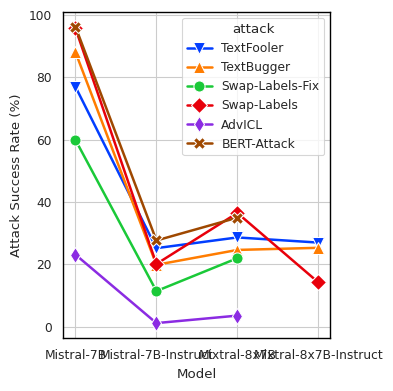

In [11]:
# plot the results as line graph with seaborn, x axis as the model, asr as y axis, hue as the attack
# transfer between llama models
sns.set_palette("bright")
sns.set_context("paper")
sns.set_style("whitegrid")
# set the font as arial
# sns.set_style({"font.sans-serif": ["Arial"]})
plt.figure(figsize=(6, 4))
# set markers as ['o', 's', 'v', 'D'], make the markers larger
fig, ax = plt.subplots(figsize=(4, 4))

for i, attack in enumerate(llama_df['attack'].unique()):
    sns.lineplot(data=mistral_df_agg[mistral_df_agg['attack'] == attack], x='model', y='asr', hue='attack', marker=markers[i], markersize=MARKERSIZE, linewidth=LINEWIDTH, palette=[colors[i]], ax=ax)
ax.set_ylabel('Attack Success Rate (%)')
ax.set_xlabel('Model')
# use balck line for the grid and also outter line
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
# remove grid
# ax.grid(axis=True)
# plt.xticks(rotation=45)
plt.tight_layout()

/var/tmp/ipykernel_1821075/393760584.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=20, rotation_mode='anchor', ha='right')


[Text(0, 0, 'Mistral-7B'),
 Text(1, 0, 'Mistral-7B-Instruct'),
 Text(2, 0, 'Mixtral-8x7B'),
 Text(3, 0, 'Mixtral-8x7B-Instruct')]

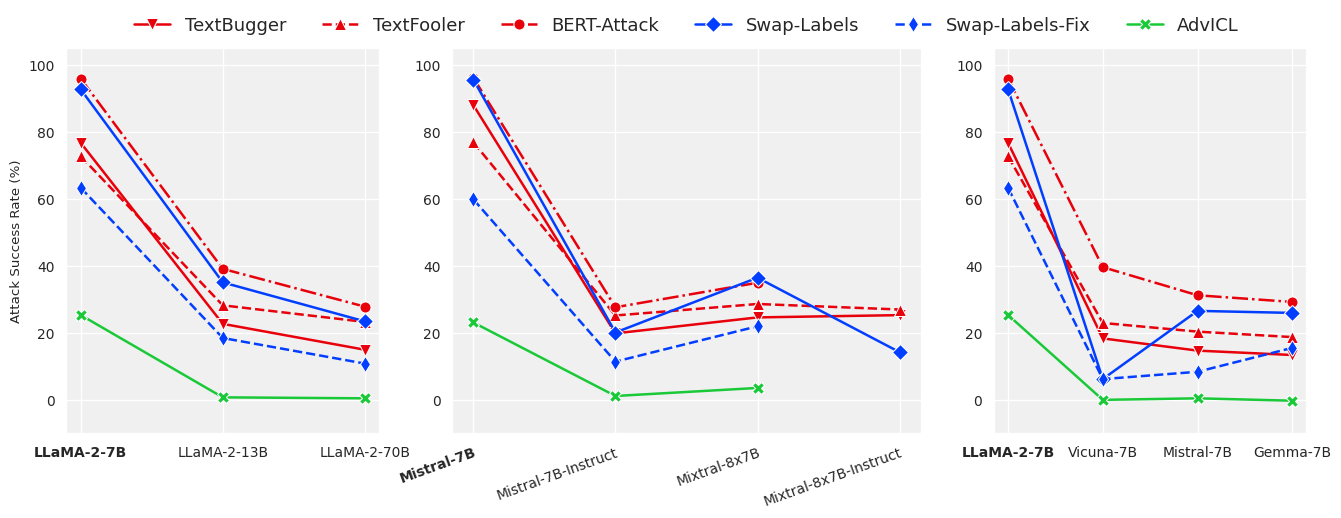

In [24]:
# draw the three graph side by side, with llama models on the left, mistral models in the middle, and the comparison on the right
# plt.rcParams["font.family"] = "sans-serif"
# plt.rcParams['font.serif'] = ['Helvetica']
colors = sns.color_palette("bright")
new_colors = [colors[3]] * 3 + [colors[0]] * 2 + [colors[2]] * 3
fig, axs = plt.subplots(1, 3, figsize=(16, 5), width_ratios=[2, 3, 2])
line_styles = ['solid', 'dashed', 'dashdot', 'solid', 'dashed', 'solid']

# share all of their legend
# have x label on the middle graph
# have the y label on the left graph

# llama models
ax = axs[0]
for i, attack in enumerate(['TextBugger', 'TextFooler', 'BERT-Attack', 'Swap-Labels', 'Swap-Labels-Fix', 'AdvICL']):
    sns.lineplot(data=llama_df[llama_df['attack'] == attack], x='model', y='asr', hue='attack', marker=markers[i], markersize=MARKERSIZE, linewidth=LINEWIDTH, palette=[new_colors[i]], ax=ax, linestyle=line_styles[i])

ax.set_ylabel('Attack Success Rate (%)')
ax.set_xlabel('')
# bold the left most xtick label
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
    break
# ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')

# use balck line only for bottom and left
# disable the legend
ax.get_legend().remove()
# add an arrow below the x axis to span the whole graph
# ax.annotate('', xy=(0, -0.1), xytext=(1, -0.1),xycoords='axes fraction', fontsize=15, ha='center', va='center', arrowprops=dict(arrowstyle='<-', lw=1, color='grey', linestyle='--'))


# mistral models
ax = axs[1]
for i, attack in enumerate(['TextBugger', 'TextFooler', 'BERT-Attack', 'Swap-Labels', 'Swap-Labels-Fix', 'AdvICL']):
    sns.lineplot(data=mistral_df_agg[mistral_df_agg['attack'] == attack], x='model', y='asr', hue='attack', marker=markers[i], markersize=MARKERSIZE, linewidth=LINEWIDTH, palette=[new_colors[i]], ax=ax, linestyle=line_styles[i])
ax.set_ylabel('')
ax.set_xlabel('', fontsize=12)
# use balck line only for bottom and left
# put the legend above the graph
# remove the legend surrounding box
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.125), ncol=7, fontsize=13, frameon=False)
# sort the legend order to be the same as the graph
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=7)
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
    break

# comparison
ax = axs[2]
for i, attack in enumerate(['TextBugger', 'TextFooler', 'BERT-Attack', 'Swap-Labels', 'Swap-Labels-Fix', 'AdvICL']):
    sns.lineplot(data=target_df[target_df['attack'] == attack], x='model', y='asr', hue='attack', marker=markers[i], markersize=MARKERSIZE, linewidth=LINEWIDTH, palette=[new_colors[i]], ax=ax, linestyle=line_styles[i])
ax.set_ylabel('')
ax.set_xlabel('')
# use balck line only for bottom and left
# disable the legend
ax.get_legend().remove()
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
    break

# have all of them ylimit from -10 to 110
for i in range(3):
    axs[i].set_ylim(-10, 105)
    # white gridline
    axs[i].grid(axis='both', color='white', linestyle='-', linewidth=1)
    # grey background
    axs[i].set_facecolor('#f0f0f0')
    axs[i].spines['top'].set_color('white')
    axs[i].spines['right'].set_color('white')
    axs[i].spines['left'].set_color('white')
    axs[i].spines['bottom'].set_color('white')
    # make both x ticks and y ticks larger
    axs[i].tick_params(axis='both', which='major', labelsize=10)
    
# rotate axs[1] x labels by 45
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=20, rotation_mode='anchor', ha='right')
# save as svg
# plt.tight_layout()
# fig.savefig('ricl_transfer_attack_success_rate.pdf', bbox_inches='tight')
# save as png
# fig.savefig('icl_transfer_attack_success_rate.png', bbox_inches='tight')

In [13]:
colors

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]